## Using Transfer Service upload data with metadata

In [166]:
import requests 
import json

dataset_meta = {
    "@context":{
        "@vocab":"http://schema.org/"
    },
    "@type":"Dataset",
    "name":"Raw Data",
    "description":"Heart Rate Measures from patient from admission to discharge.",
    "author":[
        {
            "name":"Justin Niestroy",
            "@id": "https://orcid.org/0000-0002-1103-3882",
            "affiliation":"University of Virginia"
        }
    ],
}

Below is API call to post dataset to minio and metadata to mongo

In [174]:
upload_data = requests.post(
    'https://clarklab.uvarc.io/transfer/data/',
    files = {
        'files':open('UVA_7129_HR2.csv','rb'),
        'metadata':json.dumps(dataset_meta)
    }
)

data_id = upload_data.json()['Minted Identifiers'][0]
upload_data.json()

{'All files uploaded': True,
 'Failed to mint Id for': [],
 'Minted Identifiers': ['ark:99999/017f6e7d-6ea6-45e0-a9f3-49e884602369'],
 'failed to upload': []}

## Check MDS to make sure metadata was uploaded correctly

In [143]:
metadata_request = requests.get('https://clarklab.uvarc.io/mds/' + data_id)
metadata_request.json()

{'@context': {'@vocab': 'http://schema.org/'},
 '@id': 'ark:99999/3abfd3de-843e-49b6-9288-95b38bbc0922',
 '@type': 'Dataset',
 'author': [{'@id': 'https://orcid.org/0000-0002-1103-3882',
   'affiliation': 'University of Virginia',
   'name': 'Justin Niestroy'}],
 'description': 'Heart Rate Measures from patient from admission to discharge.',
 'distribution': [{'@id': 'ark:99999/018c1a63-90d1-4ae2-87b8-cfc85366e5e7',
   '@type': 'DataDownload',
   'contentSize': 201072,
   'contentUrl': 'minio:9000/breakfast/UVA_7129_HR2.csv',
   'fileFormat': 'csv',
   'name': 'UVA_7129_HR2.csv'}],
 'name': 'Raw Data',
 'sdPublicationDate': '2020-07-29T14:12:45.858510323Z',
 'url': 'http://ors.uvadcos.io/ark:99999/3abfd3de-843e-49b6-9288-95b38bbc0922'}

## Upload Spark Script to run on newly uploaded data

In [144]:
spark_code_meta = {
    "@context":{
        "@vocab":"http://schema.org/"
    },
    "@type":"SoftwareSourceCode",
    "name":"Processing  Script",
    "description":"Sample Source Code for HCTSA test on spark",
    "author":[
        {
            "name":"Justin Niestroy",
            "@id": "https://orcid.org/0000-0002-1103-3882",
            "affiliation":"University of Virginia"
      }
    ]
}

In [145]:
upload_script = requests.post(
    'https://clarklab.uvarc.io/transfer/data/',
    files= {
        'files':open('./run_algos.py','rb'),
        'metadata':json.dumps(spark_code_meta)
    }
)

software_id = upload_script.json()['Minted Identifiers'][0]

## Submit Spark Job Using Compute Service

In [146]:
job = {
    "datasetID":data_id,
    "scriptID":software_id
}

create_job = requests.post(
    "https://clarklab.uvarc.io/compute/spark",
    json = job
)

job_id = create_job.content.decode()

In [147]:
job_id

'ark:99999/b2b59e42-5382-4694-bc69-020e5319a3c7'

## Watch Running Job

In [150]:
requests.get("http://clarklab.uvarc.io/compute/spark").json()

{'runningJobIds': ['db874b3f-d4f4-4ac2-8d89-e7b48aaf1aba']}

## Get Job outputs from job metadata

In [151]:
job_metadata_request = requests.get(
    'https://clarklab.uvarc.io/mds/' + job_id
)

job_metadata = job_metadata_request.json()
output_id = job_metadata.get('evi:supports')

In [152]:
output_id

[{'@id': 'ark:99999/67d76112-2249-48cf-984b-7d191e84e55c'},
 {'@id': 'ark:99999/44fb2719-c560-417a-b2e6-e0f001096433'}]

In [153]:
output_metadata = [ 
    requests.get('https://clarklab.uvarc.io/mds/' + out['@id']).json() for out in output_id
]

In [154]:
output_metadata

[{'@context': {'@vocab': 'http://schema.org/'},
  '@id': 'ark:99999/67d76112-2249-48cf-984b-7d191e84e55c',
  '@type': 'Dataset',
  'distribution': [{'@id': 'ark:99999/07b8cb97-00c8-4654-b99c-aad63a98caca',
    '@type': 'DataDownload',
    'contentUrl': 'minio:9000/breakfast/b2b59e42-5382-4694-bc69-020e5319a3c7/_SUCCESS',
    'fileFormat': '_SUCCESS',
    'name': '_SUCCESS'}],
  'evi:generatedBy': {'@id': 'ark:99999/b2b59e42-5382-4694-bc69-020e5319a3c7'},
  'name': '_SUCCESS',
  'sdPublicationDate': '2020-07-29T14:13:39.498354348Z',
  'url': 'http://ors.uvadcos.io/ark:99999/67d76112-2249-48cf-984b-7d191e84e55c'},
 {'@context': {'@vocab': 'http://schema.org/'},
  '@id': 'ark:99999/44fb2719-c560-417a-b2e6-e0f001096433',
  '@type': 'Dataset',
  'distribution': [{'@id': 'ark:99999/d82b8e25-c982-4d0d-80b1-679b16df0b23',
    '@type': 'DataDownload',
    'contentUrl': 'minio:9000/breakfast/b2b59e42-5382-4694-bc69-020e5319a3c7/part-00000-1fcaec2f-cbb0-4e0e-9922-51245ba2b9cb-c000.csv',
    'file

## Upload Image Code

In [155]:
spark_graphic_meta = {
    "@context":{
        "@vocab":"http://schema.org/"
    },
    "@type":"SoftwareSourceCode",
    "name":"Image Script",
    "description":"Creates heatmap of patients stay",
    "author":[
        {
            "name":"Justin Niestroy",
            "@id": "https://orcid.org/0000-0002-1103-3882",
            "affiliation":"University of Virginia"
      }
    ]
}

In [156]:
files = {
    'files':open('./make_graphic.py','rb'),
    'metadata':json.dumps(spark_graphic_meta)
}

upload_graphic_code = requests.post(
    'https://clarklab.uvarc.io/transfer/data/',
    files=files
)

graphic_code_id = upload_graphic_code.json()['Minted Identifiers'][0]
graphic_code_id

'ark:99999/1fc1e2d5-8a1a-4c51-b00c-6437990c152e'

## Run Spark Job to create Image

In [157]:
image_job = {
    "datasetID":output_id[1]['@id'],
    "scriptID": graphic_code_id
}


image_job_request = requests.post(
    "https://clarklab.uvarc.io/compute/spark",
    json = image_job
)

image_job_id =  image_job_request.content.decode()
image_job_id

'ark:99999/817493f4-1856-4d8f-a95f-21709b21aa77'

## Check on running jobs

In [160]:
requests.get("http://clarklab.uvarc.io/compute/spark").json()

{'runningJobIds': ['db874b3f-d4f4-4ac2-8d89-e7b48aaf1aba']}

### Get image ID from Updated Job ID

In [161]:
image_job_metadata = requests.get(
    'https://clarklab.uvarc.io/mds/' + image_job_id
).json()
image_id = image_job_metadata.get('evi:supports')[0]['@id']
image_id

'ark:99999/84628b61-26a1-481a-8d3d-a6b25cf8342f'

## Get the image metadata

In [162]:
image_metadata = requests.get(
    'https://clarklab.uvarc.io/mds/' + image_id
).json()
image_metadata

{'@context': {'@vocab': 'http://schema.org/'},
 '@id': 'ark:99999/84628b61-26a1-481a-8d3d-a6b25cf8342f',
 '@type': 'Dataset',
 'distribution': [{'@id': 'ark:99999/1b6115f5-b4bb-4a24-b399-5beb53d9f66f',
   '@type': 'DataDownload',
   'contentUrl': 'minio:9000/breakfast/817493f4-1856-4d8f-a95f-21709b21aa77/Histogram_Heatmap.png',
   'fileFormat': 'png',
   'name': 'Histogram_Heatmap.png'}],
 'evi:generatedBy': {'@id': 'ark:99999/817493f4-1856-4d8f-a95f-21709b21aa77'},
 'name': 'Histogram_Heatmap.png',
 'sdPublicationDate': '2020-07-29T14:14:58.465738766Z',
 'url': 'http://ors.uvadcos.io/ark:99999/84628b61-26a1-481a-8d3d-a6b25cf8342f'}

### Build Evidence graph of created image using the evidence graph service

In [163]:
evidence_graph = requests.get(
    'https://clarklab.uvarc.io/evidencegraph/eg/' + image_id
)

In [164]:
evidence_graph.json()

{'@context': {'@vocab': 'http://schema.org/', 'evi': 'http://purl.org/evi/'},
 '@id': 'ark:99999/84628b61-26a1-481a-8d3d-a6b25cf8342f',
 '@type': 'Dataset',
 'evi:generatedBy': {'@id': 'ark:99999/817493f4-1856-4d8f-a95f-21709b21aa77',
  '@type': 'evi:Computation',
  'began': 'Wednesday, July 29, 2020 02:14:27',
  'evi:usedDataset': {'@id': 'ark:99999/44fb2719-c560-417a-b2e6-e0f001096433',
   '@type': 'Dataset',
   'evi:generatedBy': {'@id': 'ark:99999/b2b59e42-5382-4694-bc69-020e5319a3c7',
    '@type': 'evi:Computation',
    'began': 'Wednesday, July 29, 2020 02:13:08',
    'evi:usedDataset': {'@id': 'ark:99999/3abfd3de-843e-49b6-9288-95b38bbc0922',
     '@type': 'Dataset',
     'author': {'@id': 'https://orcid.org/0000-0002-1103-3882',
      '@type': 'Person',
      'name': 'Justin Niestroy'},
     'name': 'Raw Data'},
    'evi:usedSoftware': {'@id': 'ark:99999/35288601-430b-4cb7-b271-481fd6124a7e',
     '@type': 'SoftwareSourceCode',
     'author': {'@id': 'https://orcid.org/0000-000

## View Visualization of the Evidence Graph

In [165]:
'https://clarklab.uvarc.io/viz/' + image_id

'https://clarklab.uvarc.io/viz/ark:99999/84628b61-26a1-481a-8d3d-a6b25cf8342f'

## Download Created Image

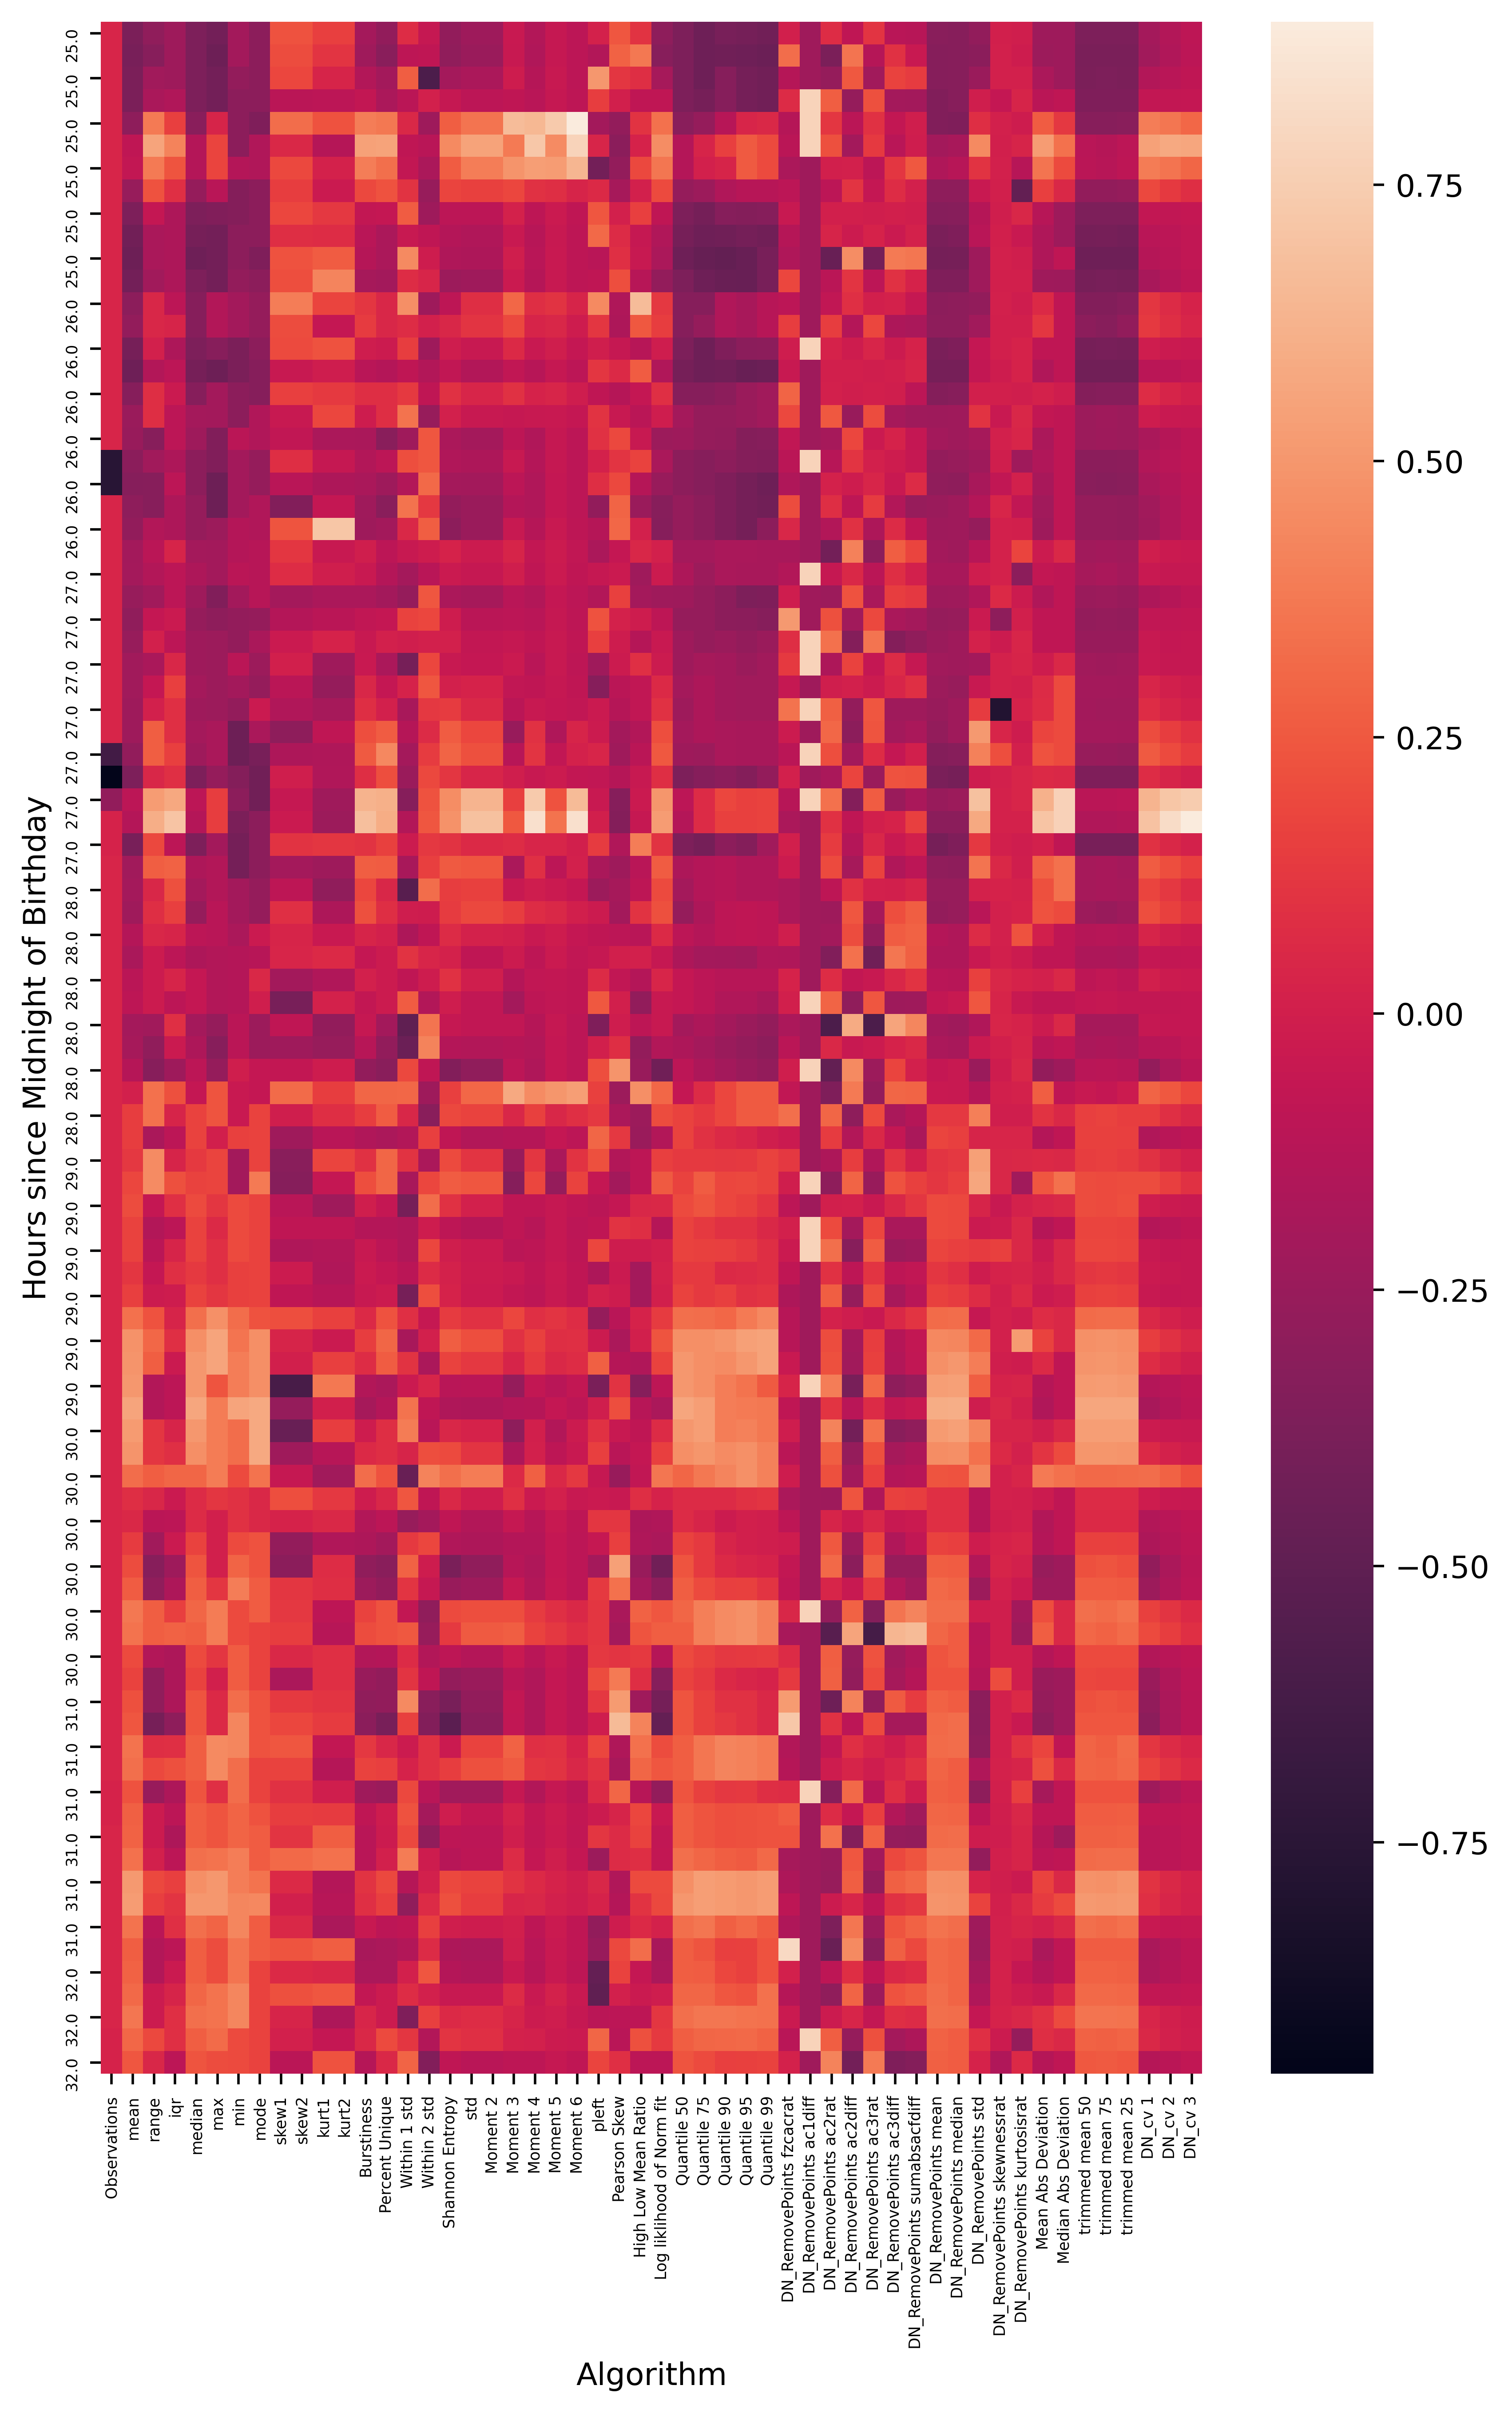

In [140]:
from IPython.display import Image
image_data = requests.get(
    'https://clarklab.uvarc.io/transfer/data/' + image_id
)
image = image_data.content
with open('Created Image.png','wb') as f:
    f.write(image)
Image(filename='Created Image.png') 